# Comparing Building Energy Consumption Predictions


In this project, we estimate the heating and cooling energy requirements of buildings using both simple physics-based principles and machine learning models using the UCI Energy Efficiency dataset. We hypothesize that if modeled correctly the machine learning model should be able to predict the heating and cooling requirements of the buildings with greater accuracy than physics principles due to the restraints of the available data.

## Steps
* Clean the dataset and set it up for use in the project
* Estimate the heating and cooling loads of the buildings using physics principles
* Estimate the heating and cooling loads of the buildings using machine learning models
* Compare both methods and draw conclusions from data

In [32]:
#Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Part 1: Exploratory Data Analysis

In [36]:
#Load Data
df = pd.read_excel(r"C:\Users\jmurp\Downloads\energy+efficiency\ENB2012_data.xlsx")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [37]:
#Check for missing entries and replace column names with provided variable descriptions
df.columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area', 'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution', 'Heating Load', 'Cooling Load']
df.isnull().sum()

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64

In [38]:
#Basic Statistics
df.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


array([[<AxesSubplot:title={'center':'Relative Compactness'}>,
        <AxesSubplot:title={'center':'Surface Area'}>,
        <AxesSubplot:title={'center':'Wall Area'}>],
       [<AxesSubplot:title={'center':'Roof Area'}>,
        <AxesSubplot:title={'center':'Overall Height'}>,
        <AxesSubplot:title={'center':'Orientation'}>],
       [<AxesSubplot:title={'center':'Glazing Area'}>,
        <AxesSubplot:title={'center':'Glazing Area Distribution'}>,
        <AxesSubplot:title={'center':'Heating Load'}>],
       [<AxesSubplot:title={'center':'Cooling Load'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

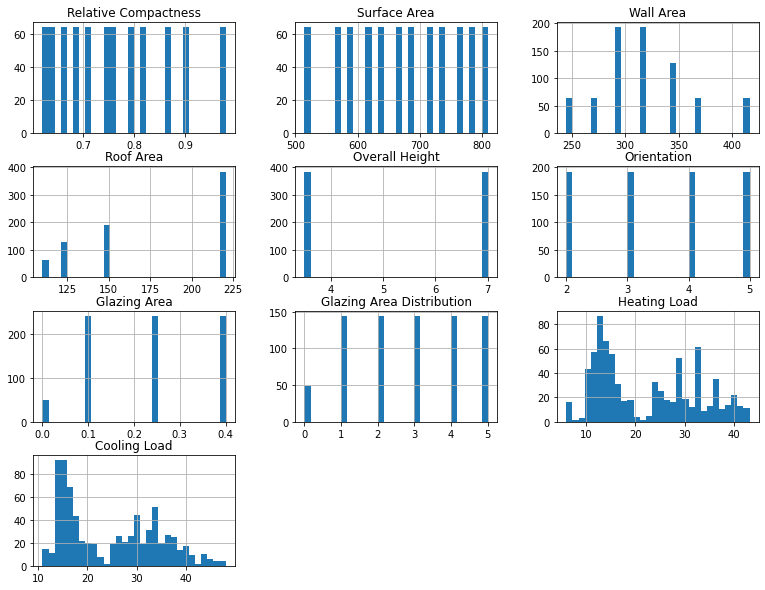

In [42]:
#Visualization of column distributions
df.hist(bins=30, figsize=(13,10))

While our target variables Heating Load and Cooling Load seem to have continuous values, the variables that explain each building's architecture are not continuous and in many places group very heavily around certain values. Overall height in particular only has values of 3.5 or 7, presuming the values to be in meters we can deduce that all buildings in the dataset are either one or two stories tall.

It is also worth noting that the heat transfer coefficient of the buildings (an integral feature for estimating heating and cooling load via physics principles) is not a variable in the dataset and was probably held constant at an unknown value when the simulated buildings were initially created.

<AxesSubplot:>

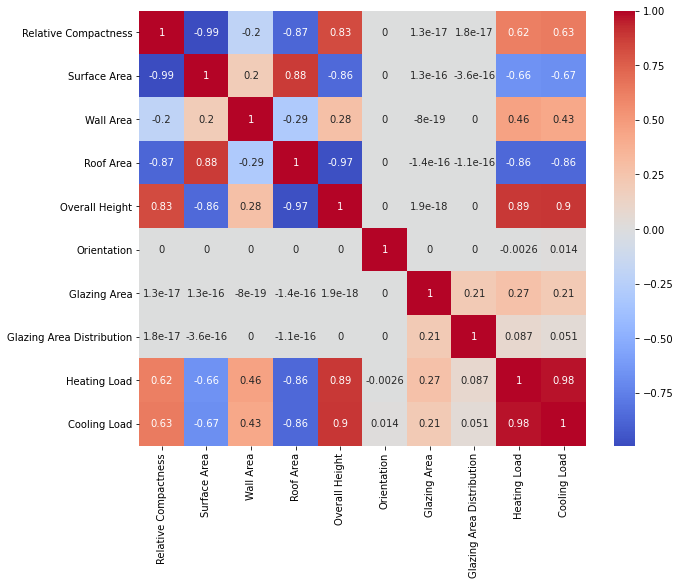

In [43]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

The heating load of a particular building is shown to have a very high correlation with the cooling load meaning that the buildings requiring more energy to heat in the winter also require more energy to cool in the summer. This heat map also confirms that each building's overall height is strongly negatively correlated with roof/surface area so the taller set of buildings tend to take up less ground space.

The surface area and relative compactness features as well as the overall height and roof area features both have correlations that are almost completely linear and therefore possibly redundant which may negatively affect the performance of some machine learning models such as linear regression, ridge, and lasso models.

## Part 2: Physics Based Estimation of Energy Load

To estimate the heating and cooling load with physics principles we'll use the formula: <br>

$ Q = U × A × ΔT $ <br>

In the formula $ Q $ is the target variable heating/cooling load, $ U $ is the heat transfer coefficient, $ A $ is the area, and $ ΔT $ is the change in temperature. The areas for each building are provided within the dataset but to perform a simple physics-based estimation, constant assumptions must be chosen for the heat transfer coefficient and temperature change.

For $ ΔT $, we will set the desired indoor temperature to 72°F/~22°C. We then choose two temperatures, 5°C/41°F and 35°C/95°F to emulate reasonable American winter and summer temperatures (the two periods where either heating or cooling a building would be most important). With these values chosen we end up with a delta_T_heating value of 22°C - 5°C = 17°C and a delta_T_cooling value of 22°C - 35°C = -13°C which we will make positive in order to avoid ending up with a negative energy value.

In [57]:
delta_T_heating = 17
delta_T_cooling = 13

For $ U $, we will need to choose a reasonable value for each of the three materials used to define the area of each building in the dataset. The creators of the UCI Energy Efficiency dataset mention in their introductory paper that the simulated buildings are modeled after modern residential houses. While the average heat transfer coefficient (or insulating capabilities) of homes have shifted slightly since the database was created in 2012 we will still be using the average heat transfer coefficients for materials found in American modern residential buildings in 2025.

Average modern wall materials have an average $U$ value between .2 and .6, roof materials have a value between .1 and .3, and window materials (or glazing materials) have values between .8 and 2.7. The values we decided to choose were as follows:

In [46]:
# U values in scientific units of measurement (W/m²·K)
U_wall = 0.35
U_roof = 0.25
U_glazing = 1.8

The values of $ Q $ found in the heating load and cooling load columns of the Energy Efficiency database are given in the normalized units kWh/m²·year so a conversion and normalization must be applied when constructing our physics based estimation to keep the comparisons fair.

### Physics Based Estimation

In [58]:
#Required Areas (m²)
A_wall = df['Wall Area']
A_roof = df['Roof Area']
A_glazing = df['Glazing Area']
A_floor = df['Surface Area']

#Required Conversions
seconds_per_year = 365 * 24 * 60 * 60
joules_per_kWh = 3.6e6

# Heating load estimate (in Watts)
Q_heating_watts = (
    U_wall*A_wall*delta_T_heating +
    U_roof*A_roof*delta_T_heating +
    U_glazing*A_glazing*delta_T_heating
)

# Cooling load estimate (in Watts)
Q_cooling_watts = (
    U_wall*A_wall*delta_T_cooling +
    U_roof*A_roof*delta_T_cooling +
    U_glazing*A_glazing*delta_T_cooling
)

# Convert from Watts (Joules/sec) to annual energy in kWh
E_heating_kWh = 

In [59]:
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Physics Heating Load,Physics Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,2217.8625,1696.0125
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,2217.8625,1696.0125
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,2217.8625,1696.0125
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,2217.8625,1696.0125
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,2415.7000,1847.3000
